In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy
from scipy.integrate import nquad

In [2]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import mixed

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

/home/ronak/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
def cef_estimate_mike_1(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    tree_idx = 0
    for tree in model:
        
        # get out of bag indices.       
        # Here's where we obtain unsampled indices.
        # unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        sampled_indices = model.estimators_samples_[tree_idx]
        unsampled_indices = np.delete(np.arange(0,X.shape[0]), sampled_indices)
        tree_idx = tree_idx + 1
        # Done with unsampled indices.
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

In [5]:
def generate_data(n, d):
    X = np.random.uniform(low=-3, high=3, size=(n, d))
    X2 = np.sum(X * X, axis = 1)
    y = np.logical_and(1 < X2, X2 < 4).astype(int)
    
    return X, y

def plot_data(n, ax):
    
    X, y = generate_data(n, 2)
        
    colors = ["#2166ac", "#c51b7d"]
    ax.scatter(X[:, 0], X[:, 1], color = np.array(colors)[y], marker = ".")
    
    ax.set_ylim(bottom = -3.1)
    ax.set_ylim(top = 3.1)
    ax.set_xlim(left = -3.1)
    ax.set_xlim(right = 3.1)
    
def compute_ball_volume(R, d):
    k = d // 2
    if np.mod(d, 2): # d is odd
        num = 2 * np.math.factorial(k) * ((4*np.pi) ** k) * (R ** (2*k + 1))
        den = np.math.factorial(2*k + 1)
        return num / den
    else: # d is even
        num = (np.pi ** k) * (R ** (2*k))
        den = np.math.factorial(k)
        return num / den
    
def compute_truth(d, base = np.exp(1)):
    annulus_volume = compute_ball_volume(2, d) - compute_ball_volume(1, d)
    cube_volume = 6**d
    
    p = annulus_volume / cube_volume
    H_Y = entropy([p, 1-p], base=base)
    
    # H_YX is zero, as Y is deterministic function of X.
    return H_Y

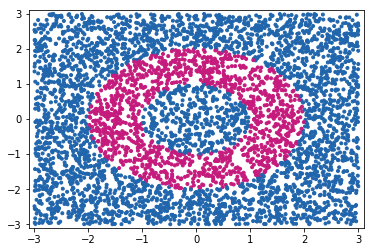

In [6]:
n = 5000

fig, ax = plt.subplots(1, 1)
plot_data(n, ax)

In [7]:
for d in range(1, 15):
    print("d =", d)
    print("I(X;Y) =", compute_truth(d))

d = 1
I(X;Y) = 0.6365141682948128
d = 2
I(X;Y) = 0.5749306184951328
d = 3
I(X;Y) = 0.39716883124191016
d = 4
I(X;Y) = 0.21895656932919094
d = 5
I(X;Y) = 0.10184725491782705
d = 6
I(X;Y) = 0.04159935346632409
d = 7
I(X;Y) = 0.015313738379505327
d = 8
I(X;Y) = 0.005170888636846258
d = 9
I(X;Y) = 0.0016216829448027089
d = 10
I(X;Y) = 0.00047679282188920846
d = 11
I(X;Y) = 0.00013237009514583886
d = 12
I(X;Y) = 3.490176461288011e-05
d = 13
I(X;Y) = 8.781060524181117e-06
d = 14
I(X;Y) = 2.116377747959832e-06


In [8]:
def estimate_mi(X, y, label, est_H_Y):
    if label == "IRF":
        try: 
            frac_eval = 0.3
            irf = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                         method='isotonic', 
                                         cv = 5)
            X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=frac_eval)
            irf.fit(X_train, y_train)
            p = irf.predict_proba(X_eval)
            return (est_H_Y - np.mean(entropy(p.T, base = np.exp(1))))
        except:
            return -1
    elif label == "UF":
        return (est_H_Y - cef_estimate_mike_1(np.array(X), y, 300, .32, depth = 30))
    elif label == "KSG":
        return mixed.KSG(X, y.reshape(-1, 1))
    elif label == "Mixed KSG":
        return mixed.Mixed_KSG(X, y.reshape(-1, 1))
    else:
        raise ValueError("Unrecognized Label!")

In [9]:
def get_mutual_info_vs_n(ns, d, num_trials, algos):
    
    def worker(t):
        X, y = generate_data(elem, d)
        
        _, counts = np.unique(y, return_counts=True)
        est_H_Y = entropy(counts, base=np.exp(1))
        
        ret = []
        for algo in algos:
            ret.append(estimate_mi(X, y, algo['label'], est_H_Y))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(ns), num_trials))
    for i, elem in enumerate(ns):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(ns, open('ns.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'wb'))
        
    return output

In [10]:
def subset_positive_results(xs, ys):
    retx = []
    rety = []
    for i in range(len(xs)):
        if ys[i] >= 0:
            retx.append(xs[i])
            rety.append(ys[i])
    return retx, rety

In [11]:
def plot_mutual_info_by_n(algos, d, ax):
    ns = pickle.load(open('ns.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_n_d_%d.pkl' % (algo['label'], d), 'rb'))
        ys = np.mean(result, axis = 1).flatten()
        xs, ys = subset_positive_results(ns, ys)
        
        # Plot the mean over trials as a solid line.
        ax.plot(xs,
                ys, 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        
    I_XY = compute_truth(d)
    truth = np.repeat(I_XY, len(ns))
    ax.plot(ns, truth, label = 'Truth', linewidth = 2, color = 'black')

    ax.set_xlabel("Sample Size")
    ax.set_xlim(left = np.amin(ns) - 1)
    ax.set_xlim(right = np.amax(ns) + 1)
    # ax.set_ylim(bottom = -0.05)
    # ax.set_ylim(top = 1.05)
    ax.set_ylabel("Estimated MI")

In [12]:
def get_mutual_info_vs_d(n, ds, num_trials, algos):
    
    def worker(t):
        X, y = generate_data(n, elem)
        
        _, counts = np.unique(y, return_counts=True)
        est_H_Y = entropy(counts, base=np.exp(1))
        
        ret = []
        for algo in algos:
            ret.append(estimate_mi(X, y, algo['label'], est_H_Y))

        return tuple(ret)
    
    output = np.zeros((len(algos), len(ds), num_trials))
    for i, elem in enumerate(ds):
        results = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        for j in range(len(algos)):
            output[j, i, :] = results[:, j]
    
    pickle.dump(ds, open('ds.pkl', 'wb'))
    for j, algo in enumerate(algos):
        pickle.dump(output[j], open('%s_by_d_n_%d.pkl' % (algo['label'], n), 'wb'))
        
    return output

In [13]:
def plot_mutual_info_by_d(algos, n, ax):
    ds = pickle.load(open('ds.pkl', 'rb'))
    for j, algo in enumerate(algos):
        result = pickle.load(open('%s_by_d_n_%d.pkl' % (algo['label'], n), 'rb'))
        ys = np.mean(result, axis = 1).flatten()
        xs, ys = subset_positive_results(ds, ys)
        
        # Plot the mean over trials as a solid line.
        ax.plot(xs,
                ys, 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])

    ax.set_xlabel("Dimensionality")
    ax.set_xlim(left = np.amin(ds) - 0.05)
    ax.set_xlim(right = np.amax(ds) + 0.05)
    # ax.set_ylim(bottom = -0.05)
    # ax.set_ylim(top = 1.05)
    ax.set_ylabel("Estimated MI")

In [14]:
def plot_fig3(algos, n, d):
    sns.set(font_scale = 2.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    fig, axes = plt.subplots(1, 3, figsize = (25,10))

    plot_data(2000, axes[0])
    plot_mutual_info_by_n(algos, d, axes[1])
    # plot_mutual_info_by_d(algos, n, axes[2])
        
    axes[0].set_title('Annulus')
    axes[1].set_title('d = %d' % d)
    axes[2].set_title('n = %d' % n)
    axes[1].legend(loc = "upper right")

    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.tight_layout()
    plt.savefig("fig8.pdf")
    plt.show()

In [15]:
# Data.
ns = range(400, 10000, 960)
d = 10
n = 10000
ds = range(1, 15)
num_trials = 20

# Fake params
# ns = range(150, 180, 10)
# d = 2
# n = 100
# ds = range(1, 3)
# num_trials = 3

# Algorithms.
algos = [
    {
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'label': 'KSG',
        'title': 'KSG',
        'color': "#1b9e77",
    },
    {
        'label': 'Mixed KSG',
        'title': 'Mixed KSG',
        'color': "purple",
    },
    {
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

In [16]:
get_mutual_info_vs_n(ns, d, num_trials, algos)

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.

In [17]:
get_mutual_info_vs_d(n, ds, num_trials, algos)

array([[[6.36435838e-01, 6.32974204e-01, 6.34859095e-01, ...,
         6.27845117e-01, 6.35757144e-01, 6.35710355e-01],
        [5.28766346e-01, 5.44675460e-01, 5.34173812e-01, ...,
         5.35255557e-01, 5.34425177e-01, 5.37024028e-01],
        [3.18698102e-01, 3.46714566e-01, 3.33442768e-01, ...,
         3.23551247e-01, 3.49102366e-01, 3.25659657e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[6.35834638e-01, 6.32976553e-01, 6.34234006e-01, ...,
         6.28919989e-01, 6.35886949e-01, 6.35991634e-01],
        [5.46443615e-01, 5.54256156e-01, 5.48924495e-01, ...,
         5.43477281e-01, 5.43909094e-01, 5.47636991e-01],
        [3.44202014e-01, 

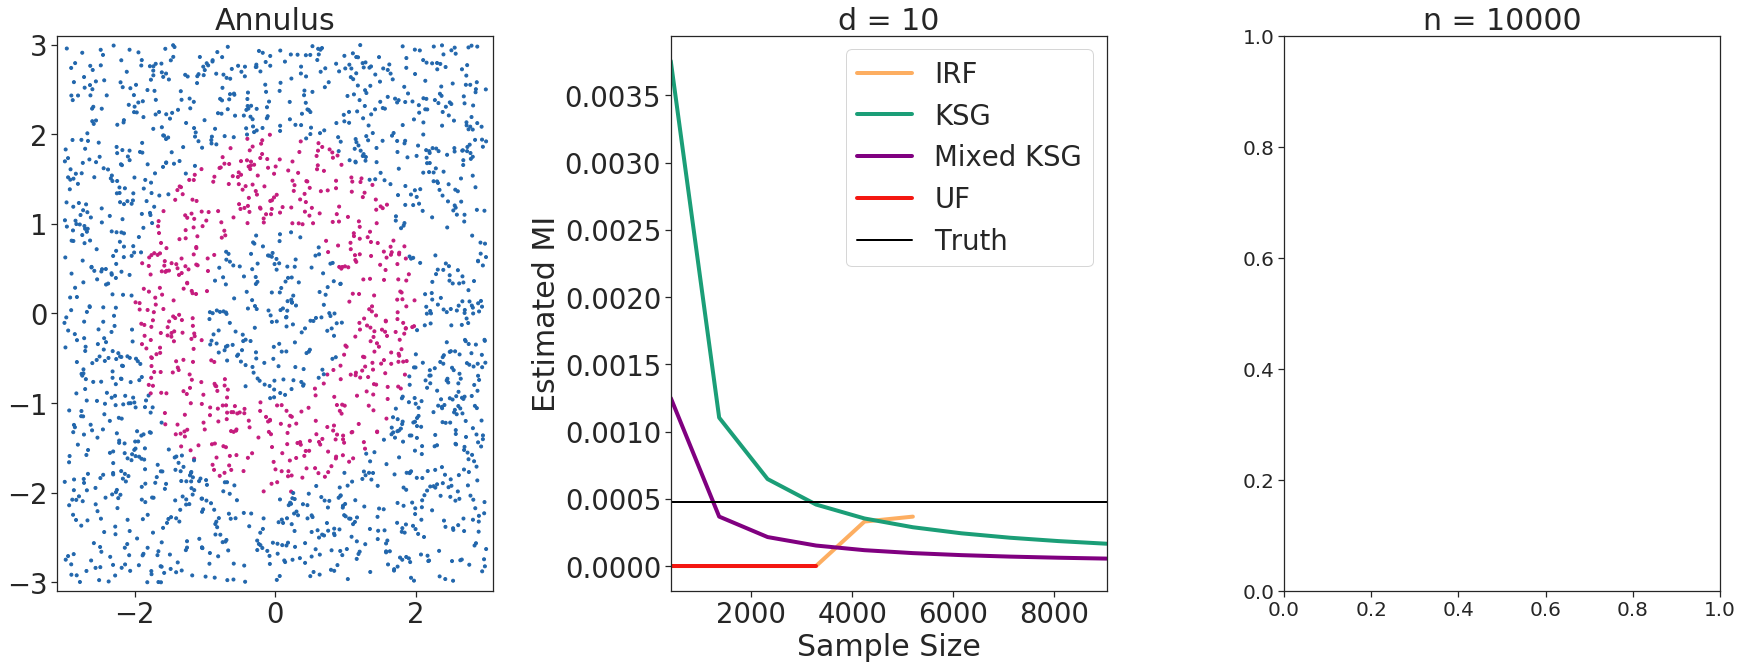

In [18]:
plot_fig3(algos, n, d)